In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

sns.set()
plt.rcParams["figure.figsize"] = (20,3)

data=pd.read_csv("SUN-SSB-20ka.txt")
data = data.drop(data.columns[3], axis=1)
data['Year'] = (data.index - 119986) / 12
data['Date'] = data['Date'].apply(lambda x: x.strip() if isinstance(x, str) else x)

# data = pd.DataFrame({
#     'Date': [
#         '2000-Jan-01', '2001-Jan-02', '2002-Jan-03', '2003-Jan-04',
#         '2004-Jan-05', '2005-Jan-06', '2006-Jan-07', '2007-Jan-08',
#         '2008-Jan-09', '2009-Jan-10'
#     ],
#     'Displacement(AU)': [15, 16, 3, 4, 5, 6, 7, 8, 9, 10],
#     'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]
# })

def get_index_by_date(data, date):
    # Returns the index of the row where the 'Date' column matches the specified date.
    if 'Date' not in data.columns:
        raise ValueError("The DataFrame must contain a 'Date' column.")

    try:
        index = data[data['Date'] == date].index[0]
    except IndexError:
        raise ValueError(f"The date '{date}' was not found in the 'Date' column.")

    return index

INTERVAL_LEN = 7200
BASE_DATE = '1500-Jan-01'
BASE_INDEX = get_index_by_date(data, BASE_DATE)
NUM_CLOSEST_INTERVALS = 50

# See the data
print(data.head())
# print(data.iloc[119986]) # Year 0 AD

           Date  Displacement(AU)  Delta(AU)         Year
0  b9999-Mar-20          0.005671   0.006265 -9998.833333
1  b9999-Apr-20          0.005783   0.006259 -9998.750000
2  b9999-May-20          0.005891   0.006226 -9998.666667
3  b9999-Jun-20          0.006002   0.006132 -9998.583333
4  b9999-Jul-20          0.006107   0.006039 -9998.500000


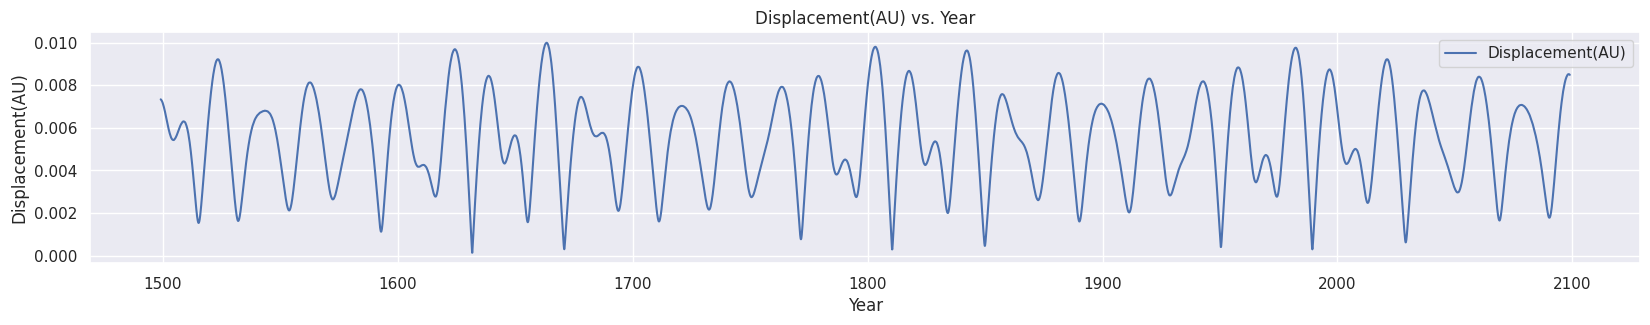

In [306]:
def extract_sub_df(data, date, length):
    # Check if the date exists in the DataFrame
    if date not in data["Date"].values:
        raise ValueError(f"The date {date} is not found in the DataFrame.")

    # Find the starting index where the 'Date' matches the given date
    start_index = data[data["Date"] == date].index[0]

    # Ensure the requested length does not exceed the DataFrame's length
    end_index = min(start_index + length, len(data))

    # Slice the DataFrame to get the subarray
    subarray = data.iloc[start_index:end_index]
    return subarray

def plot_ssb(plt, data, col):
    plt.plot(data['Year'], data[col], label=col)

    # Adding labels and title
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.title(f"{col} vs. Year")

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.show()

# Sample plot
res = extract_sub_df(data, BASE_DATE, INTERVAL_LEN)
plot_ssb(plt, res, "Displacement(AU)")

In [307]:
def dist(data, i1, i2, length):
  try:
    ans=np.sum(np.abs((np.array(data["Displacement(AU)"][i1:i1+length])-np.array(data["Displacement(AU)"][i2:i2+length]))))
  except:
    ans=-1
  return ans

# Sample distance run
# i2 = get_index_by_date(data, '2008-Jan-09')
# print(dist(data, BASE_INDEX, i2, INTERVAL_LEN))

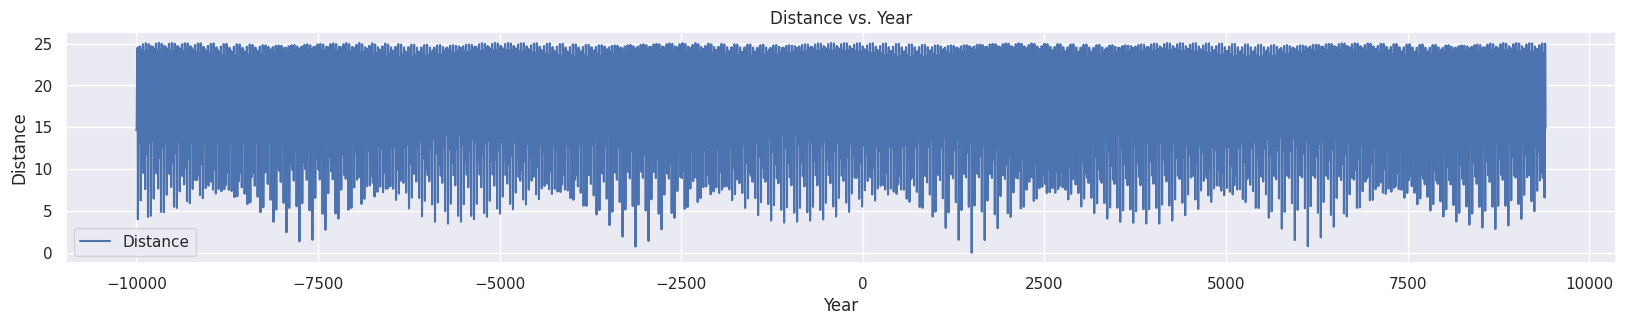

    IndexRef         Year  Distance
45   26920.0 -7755.500000  1.880136
15   26922.0 -7755.333333  1.478069
11   26924.0 -7755.166667  1.367952
13   26925.0 -7755.083333  1.440405
28   26926.0 -7755.000000  1.641707
50   26927.0 -7754.916667  1.933933
38   29068.0 -7576.500000  1.788098
27   29069.0 -7576.416667  1.638954
22   29070.0 -7576.333333  1.548985
20   29071.0 -7576.250000  1.541005
30   29072.0 -7576.166667  1.650166
44   29073.0 -7576.083333  1.853098
49   80302.0 -3307.000000  1.930220
23   82445.0 -3128.416667  1.552556
8    82446.0 -3128.333333  1.189369
6    82447.0 -3128.250000  0.909125
1    82449.0 -3128.083333  0.734763
4    82450.0 -3128.000000  0.892711
48   84592.0 -2949.500000  1.929068
35   84593.0 -2949.416667  1.705513
12   84596.0 -2949.166667  1.418684
18   84597.0 -2949.083333  1.532984
39  135825.0  1319.916667  1.806250
26  135826.0  1320.000000  1.625715
19  135827.0  1320.083333  1.539133
21  135828.0  1320.166667  1.544451
32  135829.0  1320.250000  1

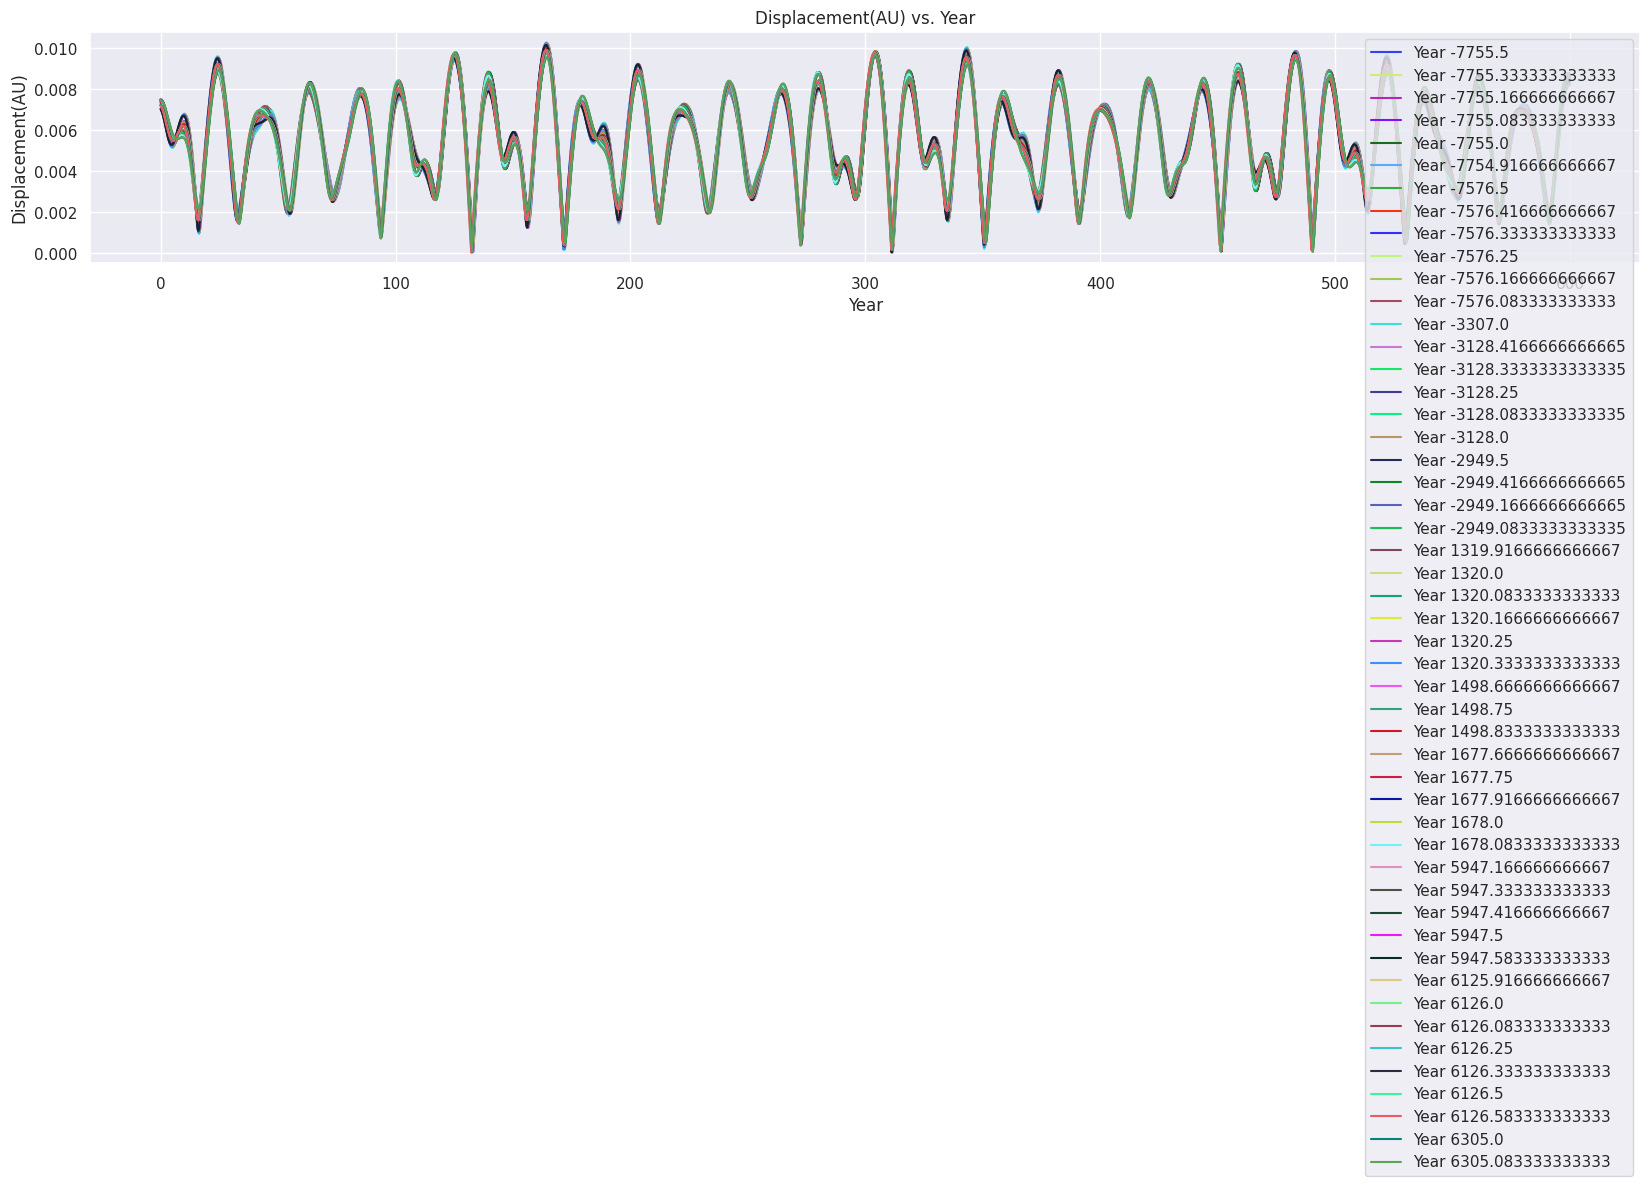

In [308]:
distances = [(i, data['Year'][i], dist(data, BASE_INDEX, i, INTERVAL_LEN)) for i in range(data.shape[0] - INTERVAL_LEN + 1)]
dist_df = pd.DataFrame(distances, columns=['IndexRef', 'Year', 'Distance'])
dist_df['IndexRef'] = dist_df['IndexRef'].astype(int)

def get_lowest_x_rows(df, num_rows, base_i):
    """
    Returns the X rows with the lowest values in the 'Distance' column.
    """
    num_rows = num_rows + 1
    # Sort DataFrame by 'Distance' column in ascending order
    sorted_df = df.sort_values(by='Distance')
    lowest_x_rows = sorted_df.head(1)
    i = 1
    while lowest_x_rows.shape[0] < num_rows:
        row = sorted_df.iloc[i]
        if abs(row['Year'] - sorted_df.iloc[i - 1]['Year']) > 10:
          lowest_x_rows.loc[lowest_x_rows.shape[0]] = row
        i += 1
    # remove the baseline interval
    lowest_x_rows = lowest_x_rows[lowest_x_rows['IndexRef'] != base_i]

    return lowest_x_rows

def generate_random_color():
    # Generate random RGB values
    r, g, b = np.random.rand(3)

    # Convert RGB values to hexadecimal format
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))

    return hex_color, (r, g, b)

def plot_ssb_lowest_intervals(plt, interval_dfs, col):
    for i in range(len(interval_dfs)):
      data = interval_dfs[i]
      color,_ = generate_random_color()
      year = data.iloc[0]['Year']
      label = f"Year {year}"
      indexes = [i / 12 for i in range(data.shape[0])]
      plt.plot(indexes, data[col], color=color, label=label)

    # Adding labels and title
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.title(f"{col} vs. Year")

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.show()

lowest_rows = get_lowest_x_rows(dist_df, NUM_CLOSEST_INTERVALS, BASE_INDEX)
plot_ssb(plt, dist_df, 'Distance')
lowest_rows = lowest_rows.sort_values(by='Year')
print(lowest_rows)
lowest_rows['IndexRef'] = lowest_rows['IndexRef'].astype(int)

# for each of the lowest rows, get the full interval dataframe. plot them all
interval_dfs = []
for row in lowest_rows.itertuples():
    full_interval = data.iloc[row.IndexRef : row.IndexRef + INTERVAL_LEN]
    interval_dfs.append(full_interval)
plot_ssb_lowest_intervals(plt, interval_dfs, 'Displacement(AU)')